Keys Highlights of analysis and stepwise summary
1. Data preprocessing
2. Build Model using [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) followed by [Regression](https://en.wikipedia.org/wiki/Linear_regression) (PCA + LR), [Neural network](https://en.wikipedia.org/wiki/Neural_network) (NN) and [Partial Least Square](http://www.statsoft.com/Textbook/Partial-Least-Squares) (PLS)
3. Evaluation and recommend best model to predict Electricity consumption

**Data preprocessing**
* Data is extracted from [csv](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv) file and column 'KWH' is selected as dependent variable. Log transform        dependent variable 'KWH' to get normally distributed Y variable. 
* Imputation indicators are discarded, and all categorical variables are converted numeric using           one hot encoding. Normalize all column data in feature variable.

**Build Models using PCR, NN and PLS**
* **PCA + LR** - Since we have 754 input features after one hot encoding, we will first reduce dimensionality of input features and consider top principal components. This will allow us to get highly variant group of features and we hope to explain Y variable using them.
* **NN** - NN is default method in such cases as we have huge number of input parameters and we don’t have to worry about feature engineering and get a best fit model just feeding all the input variables to the model
* **PLS** - Since we had very good results for first model, which was reducing dimensionality without considering Y variable, we will now reduce dimensionality considering Y variable. 

**Evaluation and recommend best model**
* For all the models, I have considered 10 fold cross validation, this allows me to consider all the available data for prediction. Models are evaluated based on 'mse'. 
* PLS method performs perfectly well to get mse of 0.064. Hence PLS is the recommended model to predict Electric consumption with R2 of 0.87
 
**Models and MSE**
* PCA + LR - 0.077 
* NN - 0.106 
* PLS - 0.064


In [2]:
%%time
#Import required packages 
import os   # get directory paths
import pandas as pd #define and work with dataframes
import numpy as np  #math and array operation
import matplotlib.pyplot as plt #plotting of graphs
from scipy.signal import savgol_filter 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras import regularizers

from sys import stdout
from sklearn.cross_decomposition import PLSRegression

#set directory paths
code_dir=%pwd
base_dir=os.path.dirname(os.path.realpath(Code_dir))
results_dir=os.path.join(Base_dir,'Results')
data_dir=os.path.join(Base_dir,'Data')


CPU times: user 123 µs, sys: 1.05 ms, total: 1.18 ms
Wall time: 1.12 ms


**[Summary about input data file](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata)**
This 2009 version represents the **13th iteration** of the RECS program. First conducted in 1978, the Residential Energy Consumption Survey is a national sample survey that collects energy-related data for housing units occupied as a primary residence and the households that live in them. Data were collected from 12,083 households selected at random using a complex multistage, area-probability sample design. The sample represents **113.6 million** U.S. households, the Census Bureau’s statistical estimate for all occupied housing units in 2009 derived from their American Community Survey (ACS).

Data is available in **[CSV](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv)**, a comma delimited file. The comma delimited data file is accompanied by a corresponding **"[Layout file](https://www.eia.gov/consumption/residential/data/2009/csv/public_layout.csv)"**, which contains descriptive labels and formats for each data variable. The **"[Variable and response codebook](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv)"** file contains descriptive labels for variables, descriptions of the response codes, and indicators for the variables used in each end-use model.

In [ ]:
%%time
#Read_data from csv file
layout_data = pd.read_csv(data_dir+'\\public_layout.csv', sep=',')
data = pd.read_csv(data_dir+'\\recs2009_public.csv', sep=',')

In [ ]:
print (layout_data.shape,data.shape)
#data file has 940 columns (each column is defined in layout_data file) with 12083 rows
data.head() #lets visualise first few rows of data file

In [4]:
#import pandas as pd
#layout_data = pd.read_csv("../input/public_layout.csv")
#data = pd.read_csv("../input/recs2009_public.csv")

As per below point from [RECS documentation summary](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf), we will just ignore imputation indicators and consider all values from the other columns
>  Imputation variables: Most variables were imputed for “Don’t Know” and “Refuse” responses. The "Z variables", also referred to as "imputation flags", are included in the public use microdata file. The imputation flag indicates whether the corresponding non-Z variable was based upon reported data (Z variable = 0) or was imputed (Z variable = 1). There are no corresponding "Z variables" for variables from the RECS questionnaire that February 2013 U.S. Energy Information Administration | 2009 Residential Energy Consumption Survey (RECS): Using the Microdata File 6 were not imputed, variables where there was no missing data, and variables that are not from the questionnaire. EIA recommends using the imputed data, where available to avoid biased estimation. 

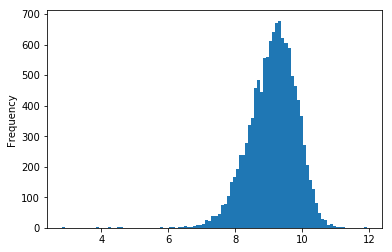

In [5]:
#Number of columns containing imputation data
discard_cols=layout_data[layout_data['Variable Label'].str.contains("Impu")]['Variable Name'].tolist() 
sel_data=data.drop(columns=discard_cols) #drop imputation indicators
Y=np.log(sel_data['KWH']) #Select and transform Dependent variable to get normal distribution
X=sel_data.drop(columns=['KWH','DOEID']) #drop Y variable and id from feature variables
Y.plot.hist(bins=100,Label='Log Electric Consumption')  #lets see distrinution of our dependent varaible

In [6]:
#From layout data file and Variable and response codebook file, below categorical variables were identified
#One hot encoding done to convert string to numeric
cat_features=['REGIONC','DIVISION','Householder_Race','Climate_Region_Pub','AIA_Zone','METROMICRO','SPOUSE','USEFO','USEWOOD','USELP','REPORTABLE_DOMAIN'
,'KOWNRENT','FOODASST','WORKPAY','ATHOME','EDUCATION','EMPLOYHH','HHSEX','WOODLOGS','KERODEL','ONSITEGRID','ONSITE','USEKERO','USESOLAR','USENG','AUDIT',
'SWIMPOOL','HIGHCEIL','AIRCOND','MOISTURE','HEATHOME','INTERNET','COMPUTER','DRYER','CWASHER','DISHWASH'
,'SEPFREEZ','STUDIO','CELLAR','BASEFIN','BASEHEAT','BASECOOL','ATTIC','PRKGPLC1','SIZEOFGARAGE','UR']
X[cat_features]=X[cat_features].astype(np.str)
X=pd.get_dummies(X)

**Principal component analysis followed by Liner Regression**

In [14]:
print (X.shape)

(12083, 754)


We have 754 features after one hot encoding. Most of the features have correlation viz. (HDD65,HDD30YR)
and (KWH,KWHSPH,KWHCOL,KWHWTH,KWHRFG), hence high colinearity. if varaibles are used as it is, High colinearity will result poor linear regression fit Hence, We  perform Principal component analysis to reduce dimension and check our regession results based on top pricipal components.

CPU times: user 11min 6s, sys: 1min 29s, total: 12min 36s
Wall time: 6min 55s


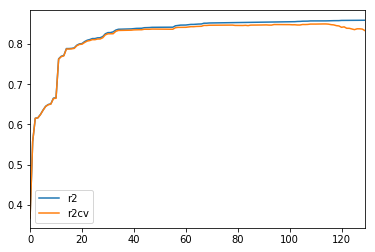

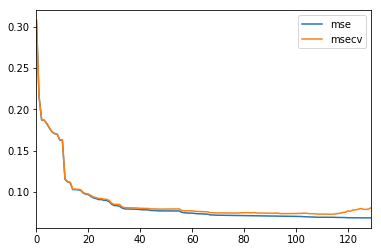

In [15]:
%%time
def pca_lr(X,y,pc):
    ''' Principal Component analysis folowed by linear regression in Python'''
    '''' PCA on feature variables'''
    # Define the PCA object
    pca = PCA()
    # Standardize features 
    Xstd = StandardScaler().fit_transform(X)
    # Run PCA and select the first pc components
    Xreg = pca.fit_transform(Xstd)[:,:pc]
    '''  Linear regression on selected principal components'''
    regr = linear_model.LinearRegression() #LR object
    regr.fit(Xreg, y) # Fit
    y_c = regr.predict(Xreg) # Calibration
    y_cv = cross_val_predict(regr, Xreg, y, cv=10) # Cross-validation
    # Calculate r square values for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mse for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

df = pd.DataFrame(columns=['predicted', 'r2', 'r2cv', 'mse', 'msecv'])
for pc in range(130):
    df.loc[pc] =pca_lr(X,Y, pc+1)
    
y=["r2","r2cv"]
df[y].plot.line()
y=['mse', 'msecv']
df[y].plot()  


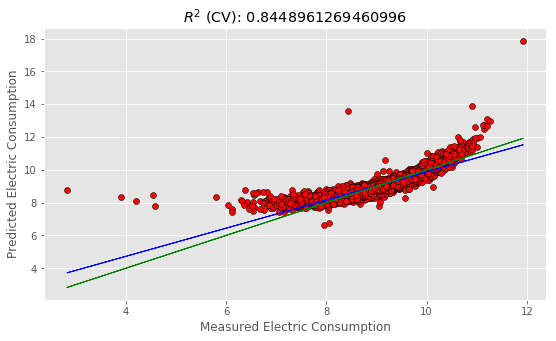

In [16]:
predicted, r2r, r2cv, mser, mscv = pca_lr(X,Y, pc=115) #it can be seen in above graph, around pc=115 mse for cross validation shoots up
# Regression plot
z = np.polyfit(Y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(Y, predicted, c='red', edgecolors='k')
    ax.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=1)
    ax.plot(Y, Y, color='green', linewidth=1)
    plt.title('$R^{2}$ (CV): '+str(r2cv))
    plt.xlabel('Measured Electric Consumption')
    plt.ylabel('Predicted Electric Consumption')
    plt.show()

The green line represent the ideal, 100%, correlation between measured and predicted values. The blue line is the actual correlation.  With R^{2}=0.84 the result is obviously good but lets see how we can improve them using other Regression methods. The main limitation of the PCA + LR approach (the fact the PCA is done without knowledge of the y values) also plays a big role in the final results.


**NEURAL NETWORK**

For NN, I have first divided data into test, train and validation data sets to get best hyper parameters and then used 10 fold cross validation to get our final scores.

In [12]:
from keras import models
from keras import layers

Xstd = StandardScaler().fit_transform(X) #standardise feature varaibles

# create training, validation and testing data sets
x_train, x_test, y_train, y_test = train_test_split(Xstd, Y, test_size=0.2)
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

k = 10
num_val_samples = len(X) // k
num_epochs = 700
all_scores = []

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001),activation='relu',input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
model = build_model()

def plot_loss_mae(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [17]:
%%time
history = model.fit(partial_x_train,partial_y_train,epochs=num_epochs,batch_size=5000,validation_data=(x_val, y_val))

Train on 8666 samples, validate on 1000 samples
Epoch 1/700
8666/8666 [==============================] - 0s 7us/step - loss: 1.4100 - mae: 0.9355 - val_loss: 0.0641 - val_mae: 0.1425
Epoch 2/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3324 - mae: 0.9077 - val_loss: 0.0691 - val_mae: 0.1524
Epoch 3/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3398 - mae: 0.9070 - val_loss: 0.0784 - val_mae: 0.1894
Epoch 4/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3391 - mae: 0.9103 - val_loss: 0.1221 - val_mae: 0.2793
Epoch 5/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3466 - mae: 0.9136 - val_loss: 0.1235 - val_mae: 0.2865
Epoch 6/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3229 - mae: 0.9108 - val_loss: 0.1233 - val_mae: 0.2815
Epoch 7/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3389 - mae: 0.9115 - val_loss: 0.1392 - val_mae: 0.3030
Epoch 8

Epoch 61/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2696 - mae: 0.8882 - val_loss: 0.1015 - val_mae: 0.2545
Epoch 62/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2791 - mae: 0.8949 - val_loss: 0.0857 - val_mae: 0.2184
Epoch 63/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2752 - mae: 0.8939 - val_loss: 0.0674 - val_mae: 0.1758
Epoch 64/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2931 - mae: 0.9010 - val_loss: 0.0518 - val_mae: 0.1194
Epoch 65/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.3192 - mae: 0.9072 - val_loss: 0.0570 - val_mae: 0.1371
Epoch 66/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2786 - mae: 0.8951 - val_loss: 0.0630 - val_mae: 0.1487
Epoch 67/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2660 - mae: 0.8895 - val_loss: 0.0697 - val_mae: 0.1699
Epoch 68/700
8666/8666 [========================

8666/8666 [==============================] - 0s 5us/step - loss: 1.2204 - mae: 0.8742 - val_loss: 0.1624 - val_mae: 0.3532
Epoch 122/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2587 - mae: 0.8870 - val_loss: 0.1007 - val_mae: 0.2581
Epoch 123/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2398 - mae: 0.8830 - val_loss: 0.0865 - val_mae: 0.2324
Epoch 124/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2263 - mae: 0.8779 - val_loss: 0.0954 - val_mae: 0.2485
Epoch 125/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2576 - mae: 0.8869 - val_loss: 0.1540 - val_mae: 0.3306
Epoch 126/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2665 - mae: 0.8867 - val_loss: 0.1490 - val_mae: 0.3308
Epoch 127/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2736 - mae: 0.8931 - val_loss: 0.1503 - val_mae: 0.3311
Epoch 128/700
8666/8666 [==============================

Epoch 181/700
8666/8666 [==============================] - 0s 20us/step - loss: 1.2137 - mae: 0.8708 - val_loss: 0.1216 - val_mae: 0.2951
Epoch 182/700
8666/8666 [==============================] - 0s 7us/step - loss: 1.2223 - mae: 0.8739 - val_loss: 0.1198 - val_mae: 0.2916
Epoch 183/700
8666/8666 [==============================] - 0s 7us/step - loss: 1.2088 - mae: 0.8699 - val_loss: 0.0990 - val_mae: 0.2603
Epoch 184/700
8666/8666 [==============================] - 0s 9us/step - loss: 1.2240 - mae: 0.8798 - val_loss: 0.0639 - val_mae: 0.1859
Epoch 185/700
8666/8666 [==============================] - 0s 8us/step - loss: 1.1690 - mae: 0.8581 - val_loss: 0.0796 - val_mae: 0.2162
Epoch 186/700
8666/8666 [==============================] - 0s 8us/step - loss: 1.1992 - mae: 0.8659 - val_loss: 0.0542 - val_mae: 0.1596
Epoch 187/700
8666/8666 [==============================] - 0s 7us/step - loss: 1.2145 - mae: 0.8746 - val_loss: 0.0513 - val_mae: 0.1491
Epoch 188/700
8666/8666 [===============

Epoch 241/700
8666/8666 [==============================] - 0s 6us/step - loss: 1.1577 - mae: 0.8547 - val_loss: 0.0718 - val_mae: 0.2127
Epoch 242/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1828 - mae: 0.8598 - val_loss: 0.0787 - val_mae: 0.2262
Epoch 243/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1541 - mae: 0.8473 - val_loss: 0.1151 - val_mae: 0.2867
Epoch 244/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1687 - mae: 0.8552 - val_loss: 0.1558 - val_mae: 0.3468
Epoch 245/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.2129 - mae: 0.8726 - val_loss: 0.1044 - val_mae: 0.2710
Epoch 246/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1911 - mae: 0.8659 - val_loss: 0.0774 - val_mae: 0.2239
Epoch 247/700
8666/8666 [==============================] - 0s 8us/step - loss: 1.1638 - mae: 0.8526 - val_loss: 0.0504 - val_mae: 0.1541
Epoch 248/700
8666/8666 [================

Epoch 301/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1569 - mae: 0.8551 - val_loss: 0.0456 - val_mae: 0.1329
Epoch 302/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1391 - mae: 0.8419 - val_loss: 0.0418 - val_mae: 0.1289
Epoch 303/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1184 - mae: 0.8391 - val_loss: 0.0602 - val_mae: 0.1863
Epoch 304/700
8666/8666 [==============================] - 0s 6us/step - loss: 1.1385 - mae: 0.8460 - val_loss: 0.0657 - val_mae: 0.1959
Epoch 305/700
8666/8666 [==============================] - 0s 7us/step - loss: 1.0925 - mae: 0.8295 - val_loss: 0.0753 - val_mae: 0.2143
Epoch 306/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1439 - mae: 0.8497 - val_loss: 0.0740 - val_mae: 0.2049
Epoch 307/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1412 - mae: 0.8456 - val_loss: 0.0579 - val_mae: 0.1643
Epoch 308/700
8666/8666 [================

Epoch 361/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1240 - mae: 0.8391 - val_loss: 0.0769 - val_mae: 0.2283
Epoch 362/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1225 - mae: 0.8384 - val_loss: 0.0808 - val_mae: 0.2363
Epoch 363/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1082 - mae: 0.8376 - val_loss: 0.0785 - val_mae: 0.2156
Epoch 364/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1187 - mae: 0.8383 - val_loss: 0.0527 - val_mae: 0.1544
Epoch 365/700
8666/8666 [==============================] - 0s 9us/step - loss: 1.1047 - mae: 0.8354 - val_loss: 0.0624 - val_mae: 0.1716
Epoch 366/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.1371 - mae: 0.8472 - val_loss: 0.0422 - val_mae: 0.1176
Epoch 367/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0738 - mae: 0.8281 - val_loss: 0.0440 - val_mae: 0.1382
Epoch 368/700
8666/8666 [================

Epoch 421/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0627 - mae: 0.8156 - val_loss: 0.1216 - val_mae: 0.3047
Epoch 422/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0739 - mae: 0.8256 - val_loss: 0.1065 - val_mae: 0.2856
Epoch 423/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0873 - mae: 0.8296 - val_loss: 0.0739 - val_mae: 0.2189
Epoch 424/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0710 - mae: 0.8189 - val_loss: 0.0545 - val_mae: 0.1765
Epoch 425/700
8666/8666 [==============================] - 0s 8us/step - loss: 1.0605 - mae: 0.8187 - val_loss: 0.0495 - val_mae: 0.1655
Epoch 426/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0869 - mae: 0.8237 - val_loss: 0.0413 - val_mae: 0.1329
Epoch 427/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0673 - mae: 0.8211 - val_loss: 0.0551 - val_mae: 0.1734
Epoch 428/700
8666/8666 [================

Epoch 481/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0715 - mae: 0.8205 - val_loss: 0.0524 - val_mae: 0.1419
Epoch 482/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0543 - mae: 0.8153 - val_loss: 0.0642 - val_mae: 0.1731
Epoch 483/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0495 - mae: 0.8121 - val_loss: 0.0509 - val_mae: 0.1628
Epoch 484/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0248 - mae: 0.8037 - val_loss: 0.0543 - val_mae: 0.1658
Epoch 485/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0401 - mae: 0.8095 - val_loss: 0.0492 - val_mae: 0.1525
Epoch 486/700
8666/8666 [==============================] - 0s 6us/step - loss: 0.9934 - mae: 0.7868 - val_loss: 0.0451 - val_mae: 0.1590
Epoch 487/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0394 - mae: 0.8082 - val_loss: 0.0372 - val_mae: 0.1136
Epoch 488/700
8666/8666 [================

Epoch 541/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0192 - mae: 0.8037 - val_loss: 0.1093 - val_mae: 0.2894
Epoch 542/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0382 - mae: 0.8058 - val_loss: 0.0752 - val_mae: 0.2307
Epoch 543/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0077 - mae: 0.7940 - val_loss: 0.0671 - val_mae: 0.2147
Epoch 544/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0004 - mae: 0.7912 - val_loss: 0.0456 - val_mae: 0.1601
Epoch 545/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9985 - mae: 0.7935 - val_loss: 0.0341 - val_mae: 0.1122
Epoch 546/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0178 - mae: 0.7981 - val_loss: 0.0429 - val_mae: 0.1306
Epoch 547/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0238 - mae: 0.8010 - val_loss: 0.0528 - val_mae: 0.1470
Epoch 548/700
8666/8666 [================

Epoch 601/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9478 - mae: 0.7716 - val_loss: 0.0418 - val_mae: 0.1394
Epoch 602/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9575 - mae: 0.7703 - val_loss: 0.0411 - val_mae: 0.1451
Epoch 603/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9598 - mae: 0.7785 - val_loss: 0.0399 - val_mae: 0.1417
Epoch 604/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9620 - mae: 0.7754 - val_loss: 0.0759 - val_mae: 0.2232
Epoch 605/700
8666/8666 [==============================] - 0s 5us/step - loss: 1.0085 - mae: 0.8008 - val_loss: 0.1108 - val_mae: 0.2908
Epoch 606/700
8666/8666 [==============================] - 0s 6us/step - loss: 1.0054 - mae: 0.7950 - val_loss: 0.1054 - val_mae: 0.2816
Epoch 607/700
8666/8666 [==============================] - 0s 6us/step - loss: 1.0079 - mae: 0.7961 - val_loss: 0.1032 - val_mae: 0.2749
Epoch 608/700
8666/8666 [================

Epoch 661/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9526 - mae: 0.7737 - val_loss: 0.0795 - val_mae: 0.2355
Epoch 662/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9616 - mae: 0.7809 - val_loss: 0.0906 - val_mae: 0.2511
Epoch 663/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9593 - mae: 0.7797 - val_loss: 0.0733 - val_mae: 0.2292
Epoch 664/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9218 - mae: 0.7650 - val_loss: 0.0576 - val_mae: 0.1929
Epoch 665/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9183 - mae: 0.7586 - val_loss: 0.0421 - val_mae: 0.1433
Epoch 666/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9676 - mae: 0.7791 - val_loss: 0.0393 - val_mae: 0.1368
Epoch 667/700
8666/8666 [==============================] - 0s 5us/step - loss: 0.9229 - mae: 0.7593 - val_loss: 0.0332 - val_mae: 0.1112
Epoch 668/700
8666/8666 [================

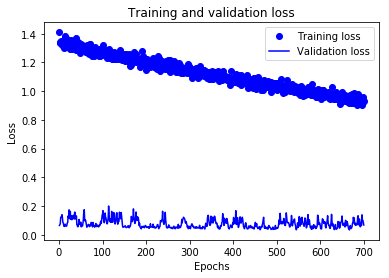

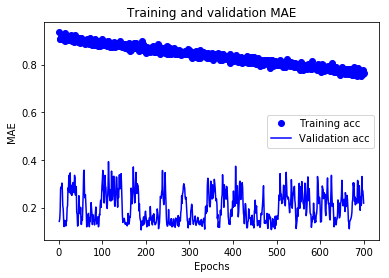

2417/2417 [==============================] - 0s 69us/step
[0.08011109975001315, 0.22321876883506775]


In [18]:
plot_loss_mae(history)
results = model.evaluate(x_test, y_test)
print (results)

In [13]:
%%time
#cross validation results
for i in range(k):
    print('processing fold #', i)
    val_data = Xstd[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([Xstd[:i * num_val_samples],
    Xstd[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([Y[:i * num_val_samples],
    Y[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=5000, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mse)

np.mean(all_scores)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
CPU times: user 13min 31s, sys: 31.9 s, total: 14min 3s
Wall time: 13min 37s


0.10659148668167213

Cross validation result (mse = 0.107) is good but not better than PCA + LR (mse = 0.077), Lets see how we can improve PCA + LR by overcoming its limitations

**PLS**

In [19]:
def pls_optimise(X, y, n_comp, plot_components=True):
    '''Execute PLS for variable number of components, up to n_comp, and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation with k =10
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        # Update status in % completion of components
        stdout.write("\r%d%% completed" % (100*(i+1)/20))
        stdout.flush()
    stdout.write("\n")

    # print the position of min in mse
    msemin = np.argmin(mse)
    print("Suggested no. of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('No. of PLS components')
            plt.ylabel('mse')
            plt.title('Partial Least Square')
            plt.xlim(left=-1)

        plt.show()

    # get PLS object with optimal no of components
    pls_opt = PLSRegression(n_components=msemin+1)

    pls_opt.fit(X, y) #fit to entire data set
    y_c = pls_opt.predict(X)

    y_cv = cross_val_predict(pls_opt, X, y, cv=10) #cross validation

    # r2 values for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # mse for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 : %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE : %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # regression plot
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # cv vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #ideal line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted Electricity Consumption')
        plt.ylabel('Measured Electricity Consumption')
        plt.show()
    return

75% completed
Suggested no. of components:  13



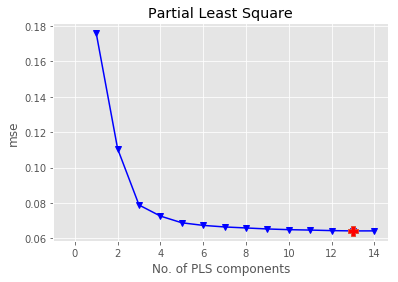

R2 : 0.884
R2 CV: 0.868
MSE : 0.056
MSE CV: 0.064


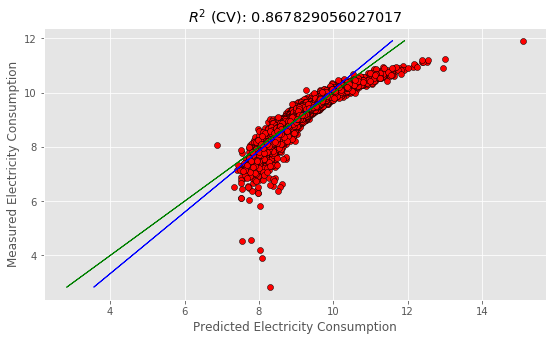

CPU times: user 3min 42s, sys: 1min 39s, total: 5min 21s
Wall time: 2min 52s


In [20]:
%%time
pls_optimise(X,Y,15, plot_components=True)

The green line represent the ideal, 100%, correlation between measured and predicted values. The blue line is the actual correlation.  With R^{2}=0.87 the result is obviously better than PCA +LR. The main limitation of the PCA + LR approach (the fact the PCA is done without knowledge of the y values) also plays a big role in the final results.

Hope you enjoyed my analysis. Thanks for reading!